# Classifier

In [1]:
#%matplotlib notebook
import os
import matplotlib.pyplot as plt
import numpy as np
from JSAnimation import IPython_display
from matplotlib import animation
import matplotlib.patches as mpatches
import cv2
import scipy.misc
import tensorflow as tf
import tensorflow.contrib.layers as c_layers
import seaborn as sns
import pandas as pd
import glob
from scipy import misc
from keras.preprocessing.image import ImageDataGenerator

c:\users\vivia\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Data Loading

In [2]:
all_classes = ['[0, 0, 0, 0]','[0, 0, 0, 1]','[0, 0, 1, 0]','[0, 1, 0, 0]','[0, 1, 1, 0]','[1, 0, 0, 0]',
               '[1, 0, 1, 0]','[2, 0, 0, 0]','[2, 0, 0, 1]','[2, 0, 1, 0]','[2, 1, 0, 0]',#'[2, 1, 1, 0]','[2,0,1,1]'
               '[3, 0, 0, 0]','[3, 0, 0, 1]','[3, 0, 1, 0]','[3, 1, 0, 0]','[4, 0, 0, 0]','[4, 0, 0, 1]',
               '[4, 0, 1, 0]']
datagen = ImageDataGenerator(validation_split=0.1)
train_it = datagen.flow_from_directory('./Results/TowerTraining/Classifier/Sorted/', class_mode='sparse',
                                       batch_size=256,shuffle=True,subset="training",target_size=(168,168),classes=all_classes)
val_it = datagen.flow_from_directory('./Results/TowerTraining/Classifier/Sorted/', class_mode='sparse',
                                       batch_size=256,shuffle=True,subset="validation",target_size=(168,168),classes=all_classes)

realLabel = []
for c,v in train_it.class_indices.items():
    c_ext = np.fromstring(c[1:-1], dtype=int, sep=', ')
    realLabel.append(c_ext)

def getRealLabel(labelBatch,RL):
    newLB = []
    for label in labelBatch:
        l = RL[int(label)]
        newLB.append(l)
    return newLB

Found 34990 images belonging to 18 classes.
Found 3879 images belonging to 18 classes.


In [3]:
num_exp = [[0,0,0,0,0],[0,0],[0,0],[0,0]]
classes = [[[0,1,2,3,4],[5,6],[7,8,9,10],[11,12,13,14],[15,16,17]],[[0,1,2,5,6,7,8,9,11,12,13,15,16,17],[3,4,10,14]],
           [[0,1,3,5,7,8,10,11,12,14,15,16],[2,4,6,9,13,17]],[[0,2,3,4,5,6,7,9,10,11,13,14,15,17],[1,8,12,16]]]
for branch in range(len(num_exp)):
    for c in range(len(num_exp[branch])):
        sum_exp = 0
        for s in classes[branch][c]:
            sum_exp = sum_exp + train_it.classes[train_it.classes==s].shape[0]
        num_exp[branch][c] = sum_exp
print('Number of samples: '+str(num_exp))
if np.sum(num_exp[0])== np.sum(num_exp[1]) == np.sum(num_exp[2]) == np.sum(num_exp[3]):
    print('all good')

Number of samples: [[14656, 1426, 12153, 3892, 2863], [32770, 2220], [32277, 2713], [33195, 1795]]
all good


In [4]:
class_weights = [[0,0,0,0,0],[0,0],[0,0],[0,0]]
print('Class Weights: ')
for branch in range(len(class_weights)):
    bincount = np.array(num_exp[branch])
    weights = np.sum(bincount) / (bincount.shape[0] * bincount)
    class_weights[branch] = weights
    print(np.round(weights,2))


Class Weights: 
[0.48 4.91 0.58 1.8  2.44]
[0.53 7.88]
[0.54 6.45]
[0.53 9.75]


In [5]:
train_it.class_indices.items()

dict_items([('[0, 0, 0, 0]', 0), ('[0, 0, 0, 1]', 1), ('[0, 0, 1, 0]', 2), ('[0, 1, 0, 0]', 3), ('[0, 1, 1, 0]', 4), ('[1, 0, 0, 0]', 5), ('[1, 0, 1, 0]', 6), ('[2, 0, 0, 0]', 7), ('[2, 0, 0, 1]', 8), ('[2, 0, 1, 0]', 9), ('[2, 1, 0, 0]', 10), ('[3, 0, 0, 0]', 11), ('[3, 0, 0, 1]', 12), ('[3, 0, 1, 0]', 13), ('[3, 1, 0, 0]', 14), ('[4, 0, 0, 0]', 15), ('[4, 0, 0, 1]', 16), ('[4, 0, 1, 0]', 17)])

## Object Classification
### Network

In [16]:
tf.reset_default_graph()

def swish(input_activation):
    """Swish activation function. For more info: https://arxiv.org/abs/1710.05941"""
    return tf.multiply(input_activation, tf.nn.sigmoid(input_activation))

o_size_h = 168
o_size_w = 168
vec_obs_size = 8
num_layers = 2
h_size = 256
h_size_vec = 256
            
visual_in = tf.placeholder(shape=[None, o_size_h, o_size_w, 3], dtype=tf.float32,name="visual_observation_0")
labels = tf.placeholder(shape=[None,4], dtype=tf.int64,name="labels")

running_mean = tf.get_variable("running_mean", [vec_obs_size],trainable=False, dtype=tf.float32,initializer=tf.zeros_initializer())
running_variance = tf.get_variable("running_variance", [vec_obs_size],trainable=False,dtype=tf.float32,initializer=tf.ones_initializer())

def create_vector_observation_encoder(observation_input, h_size, activation, num_layers, scope,reuse):
    with tf.variable_scope(scope):
        hidden_vec = observation_input
        for i in range(num_layers):
            hidden_vec = tf.layers.dense(hidden_vec, h_size, activation=activation, reuse=reuse,name="hidden_{}".format(i),kernel_initializer=c_layers.variance_scaling_initializer(1.0))
    return hidden_vec

def create_visual_observation_encoder(image_input, h_size, activation, num_layers, scope,reuse):
    with tf.variable_scope(scope):
        conv1 = tf.layers.conv2d(image_input, 16, kernel_size=[8, 8], strides=[4, 4],activation=tf.nn.elu, reuse=reuse, name="conv_1")
        conv2 = tf.layers.conv2d(conv1, 32, kernel_size=[4, 4], strides=[2, 2],activation=tf.nn.elu, reuse=reuse, name="conv_2")
        hidden_vis = c_layers.flatten(conv2)

    with tf.variable_scope(scope + '/' + 'flat_encoding'):
        hidden_flat = create_vector_observation_encoder(hidden_vis, h_size, activation,num_layers, scope, reuse)
    return hidden_flat

def create_discrete_action_masking_layer(all_logits, action_size):
        """
        Creates a masking layer for the discrete actions
        :param all_logits: The concatenated unnormalized action probabilities for all branches
        :param action_size: A list containing the number of possible actions for each branch
        :return: The action output dimension [batch_size, num_branches] and the concatenated normalized logits
        """
        action_idx = [0] + list(np.cumsum(action_size))
        raw_probs = [all_logits[:, action_idx[i]:action_idx[i + 1]] for i in range(len(action_size))]#split in action branches (size=action_size)
        normalized_probs = [
            tf.divide(raw_probs[k], tf.reduce_sum(raw_probs[k]+ 1.0e-10, axis=1, keepdims=True))
            for k in range(len(action_size))]
        #normalized_probs = raw_probs
        #output = tf.concat([tf.multinomial(tf.log(normalized_probs[k]), 1) for k in range(len(action_size))], axis=1)#sample outputs from log probdist
        output = tf.concat([tf.multinomial(tf.nn.log_softmax(raw_probs[k]), 1) for k in range(len(action_size))], axis=1)#sample outputs from log probdist
        
        log_probs = [tf.log(normalized_probs[k] + 1.0e-10) for k in range(len(action_size))]#xx
        log_probs_flat = tf.concat(log_probs, axis=1)
        return output, log_probs_flat, log_probs

visual_encoders = []
hidden_state, hidden_visual = None, None

encoded_visual = create_visual_observation_encoder(visual_in,h_size,swish,num_layers,"main_graph_0_encoder0", False)
visual_encoders.append(encoded_visual)
hidden = tf.concat(visual_encoders, axis=1)

class_size = [5,2,2,2]
policy_branches = []
for size in class_size:
    policy_branches.append(tf.layers.dense(hidden, size, activation=tf.nn.relu, use_bias=False,kernel_initializer=c_layers.variance_scaling_initializer(factor=0.01)))

all_log_probs = tf.concat([branch for branch in policy_branches], axis=1, name="action_probs")

output, normalized_logits_flat, norm_logits = create_discrete_action_masking_layer(all_log_probs, class_size)

output = tf.identity(output)
normalized_logits = tf.identity(normalized_logits_flat, name='action')#has nan in places where prob is negative bc it it log(probs)

comparison = tf.equal(labels, output)

accuracy = tf.reduce_mean(tf.cast(comparison, dtype=tf.float32))


#cross_entropies = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = norm_logits, labels = label_cat)
cross_entropiesD = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = norm_logits[0], labels = labels[:,0])
cross_entropiesK = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = norm_logits[1], labels = labels[:,1])
cross_entropiesO = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = norm_logits[2], labels = labels[:,2])
cross_entropiesP = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = norm_logits[3], labels = labels[:,3])
print(cross_entropiesD)

class_weightsD = tf.constant(class_weights[0],dtype='float32')
class_weightsK = tf.constant(class_weights[1],dtype='float32')
class_weightsO = tf.constant(class_weights[2],dtype='float32')
class_weightsP = tf.constant(class_weights[3],dtype='float32')
print(class_weightsD)

weightsD = tf.reduce_sum(class_weightsD * tf.one_hot(labels[:,0],5), axis=1)
weightsK = tf.reduce_sum(class_weightsK * tf.one_hot(labels[:,1],2), axis=1)
weightsO = tf.reduce_sum(class_weightsO * tf.one_hot(labels[:,2],2), axis=1)
weightsP = tf.reduce_sum(class_weightsP * tf.one_hot(labels[:,3],2), axis=1)
print(weightsD)
scaled_errorD = cross_entropiesD * weightsD
scaled_errorK = cross_entropiesK * weightsK
scaled_errorO = cross_entropiesO * weightsO
scaled_errorP = cross_entropiesP * weightsP

cross_entropies = tf.reduce_mean([cross_entropiesD,cross_entropiesK,cross_entropiesO,cross_entropiesP],axis=1)
print(cross_entropies)
scaled_error = tf.reduce_mean([scaled_errorD,scaled_errorK,scaled_errorO,scaled_errorP],axis=1)
# Calculate the mean cross entropy for the mini-batch 
mean_cross_entropy = tf.reduce_mean(cross_entropies)
mean_scaled_error = tf.reduce_mean(scaled_error)
# Define optimizer and minimize the mean cross entropy 
optimizer = tf.train.AdamOptimizer(0.001)

#gradients = optimizer.compute_gradients(mean_cross_entropy)
gradients = optimizer.compute_gradients(mean_scaled_error)

#training_step = optimizer.minimize(mean_scaled_error)
training_step = optimizer.minimize(mean_scaled_error)

saver = tf.train.Saver()

Tensor("SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:0", shape=(?,), dtype=float32)
Tensor("Const_1:0", shape=(5,), dtype=float32)
Tensor("Sum_4:0", shape=(?,), dtype=float32)
Tensor("Mean_1:0", shape=(4,), dtype=float32)


## Train Classifier

In [17]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

Allentropies = []
Allaccuracies = []
AllValaccuracies = []
Allscaled_errs = []
LastSave = 0

epochs = 300
for i in range(epochs):
    count = 0
    xVal,yVal = val_it.next()
    yVal = getRealLabel(yVal,realLabel)
    Valentro, Valsc_err, Valaccu,Valcomp = sess.run([mean_cross_entropy, mean_scaled_error,accuracy, comparison], feed_dict = {visual_in: xVal, labels: yVal})
    if i==0:
        print('Validation:  '+str(Valentro)+ ' - '+str(Valsc_err)+' - '+str(Valaccu))
        AllValaccuracies.append(Valaccu)
    else:
        print('Training: '+str(np.mean(entropies))+' - '+str(np.mean(scaled_errs))+' - '+str(np.mean(accuracies))+
          '    Validation:  '+str(Valentro)+ ' - '+str(Valsc_err)+' - '+str(Valaccu))
    
    if Valaccu >np.max(AllValaccuracies):
        saver.save(sess, "./Results/TowerTraining/Classifier/Model/model.ckpt")
        print('saved model')
        LastSave = i-1
    AllValaccuracies.append(Valaccu)
    for batchX, batchy in train_it:
        batchy = getRealLabel(batchy,realLabel)
        entropies = []
        accuracies = []
        scaled_errs = []
        entro, sc_err, accu,comp, _ = sess.run([mean_cross_entropy, mean_scaled_error,accuracy, comparison,training_step], feed_dict = {visual_in: batchX, labels: batchy})
        entropies.append(entro)
        accuracies.append(accu)
        scaled_errs.append(sc_err)
        #print(str(entro)+' - '+str(accu))
        if count>126:
            Allentropies.append(entropies)
            Allaccuracies.append(accuracies)
            Allscaled_errs.append(scaled_errs)
            break
        count = count+1
    

Validation:  3.9611223 - 11.268385 - 0.5205078
Training: 1.6947271 - 5.4444184 - 0.5859375    Validation:  1.6782757 - 5.290943 - 0.609375
saved model
Training: 1.292548 - 4.2038784 - 0.81933594    Validation:  1.1480972 - 3.7904615 - 0.77734375
saved model
Training: 1.3791555 - 5.268167 - 0.8144531    Validation:  1.2156196 - 5.410999 - 0.775641
Training: 1.2415866 - 4.6508574 - 0.8300781    Validation:  1.3779612 - 4.595459 - 0.8232422
saved model
Training: 1.0705884 - 4.1433363 - 0.8691406    Validation:  1.2091098 - 4.0432954 - 0.828125
saved model
Training: 1.1141522 - 3.9170153 - 0.90527344    Validation:  1.1562008 - 4.105307 - 0.85253906
saved model
Training: 1.2530887 - 4.3656173 - 0.8671875    Validation:  1.3136796 - 4.6104345 - 0.83496094
Training: 1.0842298 - 4.3175163 - 0.8203125    Validation:  1.1249568 - 4.2468567 - 0.8251953
Training: 1.3791769 - 4.310735 - 0.6689453    Validation:  1.4766569 - 5.2260876 - 0.63964844
Training: 1.5560126 - 5.7342143 - 0.69921875    Val

Training: 0.9594232 - 3.8955286 - 0.88183594    Validation:  1.3496108 - 5.32152 - 0.8359375
Training: 1.0257685 - 4.522977 - 0.88378906    Validation:  0.91996384 - 2.953371 - 0.8574219
Training: 1.0687897 - 4.1881776 - 0.8623047    Validation:  1.1516429 - 3.4269686 - 0.84375
Training: 1.469882 - 4.3457065 - 0.6875    Validation:  1.4334427 - 4.7520247 - 0.68652344
Training: 1.340056 - 4.3557696 - 0.8017578    Validation:  1.3461971 - 4.9920197 - 0.8027344
Training: 1.3998148 - 3.9065454 - 0.6386719    Validation:  1.9636402 - 6.6373587 - 0.58984375
Training: 1.3027133 - 4.42807 - 0.82421875    Validation:  1.3123251 - 4.3334475 - 0.81347656
Training: 1.3526402 - 5.236301 - 0.84277344    Validation:  1.440664 - 5.2114406 - 0.81640625
Training: 1.3570415 - 3.6861699 - 0.66796875    Validation:  1.5573401 - 5.131642 - 0.6142578
Training: 0.9836251 - 3.2777572 - 0.8515625    Validation:  1.4057008 - 4.3122 - 0.8173828
Training: 1.2452743 - 4.4707994 - 0.8671875    Validation:  1.2394569

Training: 0.8271844 - 3.906278 - 0.9326172    Validation:  1.7297827 - 6.0390396 - 0.86328125
Training: 0.7100504 - 3.4794888 - 0.93847656    Validation:  1.4743844 - 4.867804 - 0.87890625
Training: 1.0450344 - 4.975798 - 0.9375    Validation:  1.4360834 - 5.297989 - 0.8964844
Training: 0.7256717 - 3.5119581 - 0.9589844    Validation:  1.3780334 - 5.3042164 - 0.9140625
Training: 0.78577685 - 3.6764114 - 0.953125    Validation:  1.3168428 - 5.1192694 - 0.90625
Training: 0.91113913 - 4.5696425 - 0.95703125    Validation:  1.6866693 - 4.388522 - 0.90384614
Training: 0.9508901 - 3.9464164 - 0.9111328    Validation:  1.4276273 - 5.997711 - 0.87402344
Training: 0.9192409 - 4.4938107 - 0.94921875    Validation:  1.3692167 - 5.0643616 - 0.89453125
Training: 0.9880943 - 4.2057805 - 0.9511719    Validation:  1.5198486 - 4.791952 - 0.9082031
Training: 1.0237381 - 4.596396 - 0.9482422    Validation:  1.364279 - 4.648589 - 0.9160156
Training: 0.76230717 - 3.4192116 - 0.9580078    Validation:  1.814

Training: 0.56504226 - 1.0376589 - 0.8408203    Validation:  1.0316548 - 1.749004 - 0.7939453
Training: 0.4600759 - 0.78477496 - 0.84375    Validation:  1.1063563 - 1.5759966 - 0.7792969
Training: 0.65854496 - 1.2023485 - 0.84472656    Validation:  1.5120367 - 2.6744576 - 0.7988281
Training: 0.7511383 - 1.4811256 - 0.84765625    Validation:  1.1898412 - 2.0591307 - 0.7998047
Training: 0.6356942 - 1.2220738 - 0.8613281    Validation:  1.4651375 - 2.745553 - 0.79589844
Training: 0.6573648 - 1.323253 - 0.8652344    Validation:  1.3381411 - 2.3785276 - 0.8076172
Training: 0.6051334 - 1.1400869 - 0.8652344    Validation:  1.3763415 - 2.478304 - 0.81640625
Training: 0.7065605 - 1.329364 - 0.8466797    Validation:  1.4466317 - 2.6791174 - 0.78125
Training: 0.4735658 - 0.88081884 - 0.8642578    Validation:  1.8009439 - 3.9203386 - 0.77441406
Training: 0.55803746 - 1.037024 - 0.83496094    Validation:  1.3212345 - 2.1714807 - 0.7832031
Training: 0.56517696 - 1.0497038 - 0.84375    Validation:  

## Plot Performance

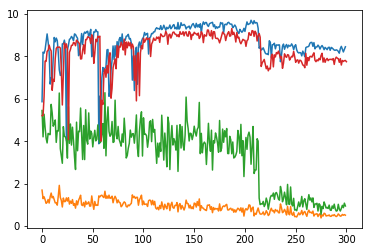

In [18]:
plt.figure()
plt.plot(np.multiply(Allaccuracies,10))
plt.plot(Allentropies)
plt.plot(Allscaled_errs)
plt.plot(np.multiply(AllValaccuracies,10))
plt.show()

## Save Statistics

In [19]:
np.save("./Results/TowerTraining/Classifier/Model/Accs.npy",Allaccuracies)
np.save("./Results/TowerTraining/Classifier/Model/Entro.npy",Allentropies)
np.save("./Results/TowerTraining/Classifier/Model/Err.npy",Allscaled_errs)
np.save("./Results/TowerTraining/Classifier/Model/ValAcc.npy",AllValaccuracies)